In [1]:
import pandas as pd
from sklearn.model_selection import train_test_split
import numpy as np
import deepxde as dde
import tensorflow as tf


# Load the Excel file into a pandas DataFrame
df = pd.read_excel('Hydrostatic Data with Nodes.xlsx')  # Replace with your file path

# Sample n points randomly from the DataFrame
n = 100  # Specify how many points you want to sample
sampled_data = df.sample(n=n)

# Split the data into training (60%) and testing (40%)
train_data, test_data = train_test_split(sampled_data, test_size=0.4, random_state=42)

# Training data
x_train = np.array(train_data['x'].values).reshape(-1, 1)  # Extract the x values for training
y_train = np.array(train_data['y'].values).reshape(-1, 1)   # Extract the y values for training
sigma_train =np.array(train_data['sigma'].values).reshape(-1, 1)  # Extract the sigma values for training

# Testing data
x_test = np.array(test_data['x'].values).reshape(-1, 1)  # Extract the x values for testing
y_test = np.array(test_data['y'].values).reshape(-1, 1)  # Extract the y values for testing
sigma_test = np.array(test_data['sigma'].values).reshape(-1, 1) # Extract the sigma values for testing

print(x_train)
print(y_train)
print(sigma_train)
Com=np.stack((x_train,y_train))
com=Com.T
print(com)


Using backend: tensorflow.compat.v1
Other supported backends: tensorflow, pytorch, jax, paddle.
paddle supports more examples now and is recommended.



Instructions for updating:
non-resource variables are not supported in the long term
[[0.00428761]
 [0.02672495]
 [0.00066446]
 [0.00531479]
 [0.03885189]
 [0.05097884]
 [0.02672495]
 [0.0479471 ]
 [0.00330071]
 [0.04592595]
 [0.0011887 ]
 [0.01560858]
 [0.03986248]
 [0.00834171]
 [0.00356185]
 [0.02773553]
 [0.04087305]
 [0.02470379]
 [0.00417275]
 [0.00638316]
 [0.04996826]
 [0.00521357]
 [0.00630751]
 [0.04390479]
 [0.01251257]
 [0.02672495]
 [0.00246194]
 [0.00834171]
 [0.04491537]
 [0.00619837]
 [0.04087305]
 [0.007299  ]
 [0.00664848]
 [0.04693653]
 [0.014598  ]
 [0.02470379]
 [0.00236609]
 [0.00413458]
 [0.04087305]
 [0.04693653]
 [0.00424685]
 [0.00489146]
 [0.03885189]
 [0.01042714]
 [0.00445204]
 [0.0479471 ]
 [0.00560071]
 [0.00339555]
 [0.00246266]
 [0.00834171]
 [0.00155186]
 [0.00089064]
 [0.007299  ]
 [0.05097884]
 [0.00141483]
 [0.0090645 ]
 [0.00025824]
 [0.0043746 ]
 [0.03076726]
 [0.01255859]]
[[0.00036473]
 [0.03805356]
 [0.00446779]
 [0.00209561]
 [0.04603409]
 [0

In [3]:
data_x=np.column_stack((x_train,y_train))
data_x=data_x
print(data_x.shape)
data_sigma=np.array(sigma_train)
test_x=np.column_stack((x_test,y_test))
test_x=test_x
print(test_x.shape)
test_sigma=np.array(sigma_test)

from sklearn.preprocessing import StandardScaler

# Apply StandardScaler to the training and testing data
scaler_x = StandardScaler()
scaler_s = StandardScaler()

data_x = scaler_x.fit_transform(data_x)
data_sigma=scaler_s.fit_transform(data_sigma)
test_x = scaler_x.transform(test_x)
test_sigma=scaler_s.transform(test_sigma)

print(data_x)
print(data_sigma)
data = dde.data.dataset.DataSet(X_train=data_x, y_train=data_sigma, X_test=test_x, y_test=test_sigma)

(60, 2)
(40, 2)
[[-0.81491977 -1.03934977]
 [ 0.46433698  0.73158939]
 [-1.02149206 -0.84655311]
 [-0.75635512 -0.95801821]
 [ 1.15575035  1.10658153]
 [ 1.84716383  0.02847914]
 [ 0.46433698  1.29407769]
 [ 1.67431041  1.20032961]
 [-0.87118738 -0.89688889]
 [ 1.55907472 -0.48811568]
 [-0.99160262 -0.86673709]
 [-0.16945865 -0.86703033]
 [ 1.2133683   0.91908555]
 [-0.58377622  0.77846343]
 [-0.85629845 -0.95532005]
 [ 0.52195482  0.07535318]
 [ 1.27098604  1.20032961]
 [ 0.3491014   1.62219579]
 [-0.82146844 -0.85702908]
 [-0.69544222 -0.96908202]
 [ 1.7895461   1.57532175]
 [-0.76212613  1.29407769]
 [-0.69975582 -0.42897747]
 [ 1.44383925  1.57532175]
 [-0.34597638  1.01283345]
 [ 0.46433698  1.34095155]
 [-0.91900959 -0.84392262]
 [-0.58377622  1.57532175]
 [ 1.50145699 -0.81966599]
 [-0.70597796 -0.97675705]
 [ 1.27098604 -0.11214289]
 [-0.64322619  0.07535318]
 [-0.68031564 -1.02465759]
 [ 1.61669267  1.57532175]
 [-0.22707644  1.52844771]
 [ 0.3491014  -1.05648766]
 [-0.9244742

Compiling model...
Building feed-forward neural network...



c:\Users\yesda\Documents\GitHub\PINN_testing\.conda\Lib\site-packages\deepxde\nn\tensorflow_compat_v1\fnn.py:116: UserWarning: `tf.layers.dense` is deprecated and will be removed in a future version. Please use `tf.keras.layers.Dense` instead.
  return tf.layers.dense(


'build' took 0.206631 s


'compile' took 0.404045 s

Training model...

Step      Train loss    Test loss     Test metric
0         [1.19e+00]    [1.46e+00]    []  
1000      [4.55e-01]    [6.84e-01]    []  
2000      [1.84e-01]    [2.16e-01]    []  
3000      [1.49e-01]    [1.88e-01]    []  
4000      [2.94e-02]    [4.12e-02]    []  
5000      [1.63e-03]    [4.48e-03]    []  
6000      [5.31e-04]    [3.45e-03]    []  
7000      [2.44e-04]    [2.80e-03]    []  
8000      [9.68e-05]    [2.17e-03]    []  
9000      [3.56e-05]    [1.79e-03]    []  
10000     [1.91e-05]    [1.61e-03]    []  
11000     [1.41e-05]    [1.48e-03]    []  
12000     [1.16e-05]    [1.39e-03]    []  
13000     [1.95e-05]    [1.29e-03]    []  
14000     [7.86e-06]    [1.24e-03]    []  
15000     [6.75e-06]    [1.19e-03]    []  
16000     [5.94e-06]    [1.14e-03]    []  
17000     [5.29e-06]    [1.10e-03]    []  
18000     [5.25e-06]    [1.06e-03]    []  
19000     [4.29e-06]    [1.03e-03]    []  
20000     [3.93e-0

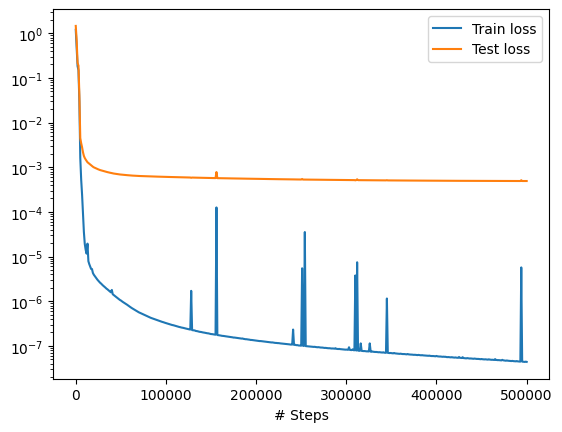

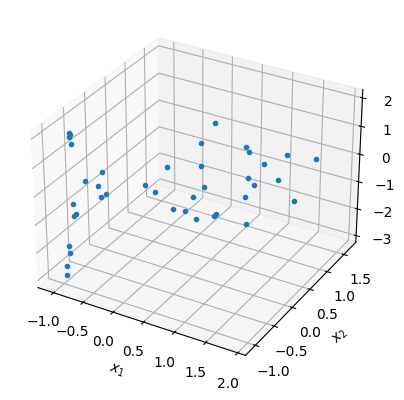

In [4]:


# Define the network for σ
layer_size = [2] + [60] * 10 + [1]  # 2 inputs (x, y ) -> hidden layers -> 1 output (σ)
activation = "tanh"
initializer = "Glorot uniform"
net_sigma = dde.nn.FNN(layer_size, activation,initializer)

# Define the model
model_sigma = dde.Model(data, net_sigma)

# Compile the model with data
model_sigma.compile("adam", lr=1e-5)

# Train the model
losshistory, train_state = model_sigma.train(epochs=500000)

dde.saveplot(losshistory, train_state, issave=True, isplot=True)

In [231]:
Vdata=np.array([[0.008341715,0.030073043]])
Vdata=scaler_x.transform(Vdata)
verify=model_sigma.predict(Vdata)
# Convert predictions back to original scale
predictions_original_scale = scaler_s.inverse_transform(verify)

# Print the predictions in the original scale
print(predictions_original_scale)


[[42621804.]]


In [21]:

X=df.iloc[:,1]
print(X)
X=np.array(X.tolist()).reshape(-1,1)

Y=df.iloc[:,2]
Y=np.array(Y.tolist()).reshape(-1,1)
print(Y)
Cor=np.column_stack([X,Y])
print(Cor)
Cor=scaler_x.transform(Cor)

0       0.000000
1      20.000013
2      20.000013
3      20.000010
4      20.000010
         ...    
96     20.000328
97     20.000332
98     20.000339
99     20.000345
100    20.000349
Name: node_1, Length: 101, dtype: float64
[[ 0.       ]
 [20.0000038]
 [20.0000057]
 [20.0000076]
 [20.0000076]
 [20.0000076]
 [20.0000114]
 [20.0000114]
 [20.0000076]
 [20.0000095]
 [20.0000114]
 [20.0000153]
 [20.0000134]
 [20.0000153]
 [20.0000153]
 [20.0000191]
 [20.0000172]
 [20.0000191]
 [20.0000191]
 [20.000021 ]
 [20.0000229]
 [20.0000229]
 [20.0000267]
 [20.0000229]
 [20.0000267]
 [20.0000267]
 [20.0000248]
 [20.0000267]
 [20.0000267]
 [20.0000267]
 [20.0000267]
 [20.0000267]
 [20.0000267]
 [20.0000267]
 [20.0000267]
 [20.0000267]
 [20.0000229]
 [20.0000229]
 [20.0000191]
 [20.0000153]
 [20.0000114]
 [20.0000057]
 [20.       ]
 [19.9999981]
 [19.9999886]
 [19.9999847]
 [19.9999771]
 [19.9999695]
 [19.9999638]
 [19.9999523]
 [19.9999428]
 [19.9999332]
 [19.9999237]
 [19.9999123]
 [19.9999027]
 

Mean Absolute Percentage Error: 23.89%
R² Score: 1.00


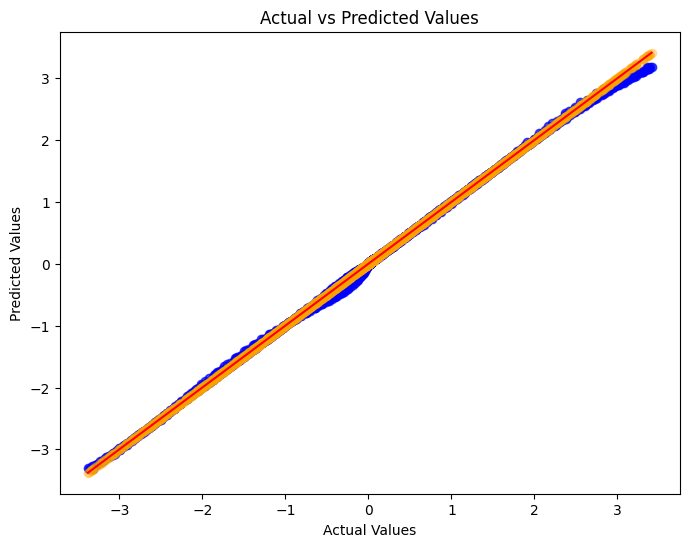

In [15]:
import matplotlib.pyplot as plt
from sklearn.metrics import mean_absolute_percentage_error, r2_score

# Assuming `model_sigma` is your trained model
# `X_test` is your test input data and `y_test` is the actual test output data

# Get predictions on test data
S_p = model_sigma.predict(Cor)
S_t=df.iloc[:,3]
#print(S_t)
S_t=np.array(S_t.tolist()).reshape(-1,1)
S_t=scaler_s.transform(S_t)
#print("First few actual values:", S_t[:5])
#print("First few predicted values:", S_p[:5])
# Calculate Mean Absolute Percentage Error (MAPE)
mape = mean_absolute_percentage_error(S_t, S_p) * 100
print(f"Mean Absolute Percentage Error: {mape:.2f}%")

# Calculate R² Score
r2 = r2_score(S_t, S_p)
print(f"R² Score: {r2:.2f}")

# Plot the actual vs predicted values for test data
plt.figure(figsize=(8, 6))

# Scatter plot for actual values
plt.scatter(S_t, S_p, alpha=0.7, color='blue', label='Predicted Values')
# Scatter plot for testing data (Actual Values)
plt.scatter(S_t, S_t, alpha=0.3, color='orange', label='Actual Values')
plt.plot([min(S_t), max(S_t)], [min(S_t), max(S_t)], color='red')  # Identity line
plt.xlabel('Actual Values')
plt.ylabel('Predicted Values')
plt.title('Actual vs Predicted Values')
plt.show()


In [5]:
def pde_C_L(x, C_L):
    dC_L_dt = dde.grad.jacobian(C_L, x, i=0, j=2)
    dC_L_dx2 = dde.grad.hessian(C_L, x, i=0, j=0)
    dC_L_dy2 = dde.grad.hessian(C_L, x, i=0, j=1)
    eq = dC_L_dt - (1/3.8) * (dC_L_dx2 + dC_L_dy2)
    return eq

Compiling model...
Building feed-forward neural network...
'build' took 0.042810 s



c:\Users\yesda\Documents\GitHub\PINN_testing\.conda\Lib\site-packages\deepxde\nn\tensorflow_compat_v1\fnn.py:116: UserWarning: `tf.layers.dense` is deprecated and will be removed in a future version. Please use `tf.keras.layers.Dense` instead.
  return tf.layers.dense(


'compile' took 0.448074 s

Training model...

Step      Train loss              Test loss               Test metric
0         [2.51e-02, 4.00e+02]    [2.44e-02, 4.00e+02]    []  
Constraint loss after epoch: 0.019665206214176577
Constraint loss after epoch: 0.09267693439032883
Constraint loss after epoch: 0.03882035333663225
Constraint loss after epoch: 0.12628241672646254
Constraint loss after epoch: 0.4287926672433969
Constraint loss after epoch: 0.1701510248833074
Constraint loss after epoch: 0.34577773287892344
Constraint loss after epoch: 1.4877060890197753
Constraint loss after epoch: 0.7827913358807563
Constraint loss after epoch: 0.2364220030605793
Constraint loss after epoch: 1.5795519747771323
Constraint loss after epoch: 0.6498334568925201
Constraint loss after epoch: 0.9202767312526703
Constraint loss after epoch: 0.9155141562223434
Constraint loss after epoch: 1.134510563313961
Constraint loss after epoch: 0.4106862097978592
Constraint loss after epoch: 0.9320193914696574


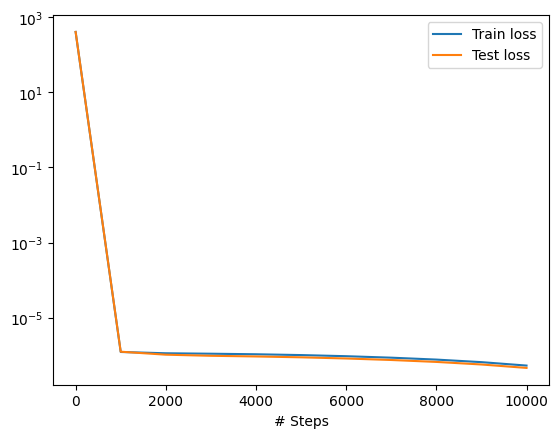

In [15]:
R = 0.1 #4e-3
L= 1 #12e-2
t_last= 1 #4.2e5


# Define the square domain (e.g., 2x2 square with side length L)

square = dde.geometry.Rectangle([-L, -L], [L, L])

# Define the circular hole at the center (radius R)
  # Radius of the hole
circle = dde.geometry.Disk([0, 0], R)

# Geometry and time domain
geom = dde.geometry.csg.CSGDifference(square, circle)
timedomain = dde.geometry.TimeDomain(0, t_last)
geomtime = dde.geometry.GeometryXTime(geom, timedomain)

# Define Dirichlet boundary conditions (e.g., C = 0 on the boundaries)
def boundary_condition(x, on_boundary):
    return on_boundary

# Create the initial and boundary conditions
ic = dde.icbc.IC(geomtime, lambda x: 20, lambda _, on_initial: on_initial)


data = dde.data.TimePDE(
    geomtime,
    pde_C_L,[ic],
    num_domain=1000,
    num_boundary=150,
    num_initial=180,
    num_test=1000,
    )

# Network for C_L
layer_size = [3] + [64] * 5 + [1]  
activation = "tanh"
initializer = "Glorot uniform"
net_C_L = dde.nn.FNN(layer_size, activation, initializer)



class RandomPointConstraintCallback(dde.callbacks.Callback):
    def __init__(self, num_pairs, model_sigma, L, t_last, model):
        self.num_pairs = num_pairs
        self.model_sigma = model_sigma
        self.L = L
        self.t_last = t_last
        self.model = model  # Attach the model to the callback

    def on_epoch_end(self):
        # Access the model from train_state
    

        constraint_loss = 0.0
        for _ in range(self.num_pairs):
            # Sample random points in the domain
            x_A, y_A = np.random.uniform(-self.L, self.L), np.random.uniform(-self.L, self.L)
            x_B, y_B = np.random.uniform(-self.L, self.L), np.random.uniform(-self.L, self.L)

            # Get sigma values for random points
            sigma_A = self.model_sigma.predict(np.array([[x_A, y_A]]))
            sigma_B = self.model_sigma.predict(np.array([[x_B, y_B]]))

            # Compute the constraint
            VH, R, T = 2e-6, 8.34, 298  # Modify constants as needed
            exponent = (VH / (R * T)) * (sigma_A - sigma_B)

            # Get C values at the random points
            C_A = model.predict(np.array([[x_A, y_A, self.t_last]]))
            C_B = model.predict(np.array([[x_B, y_B, self.t_last]]))

            # Calculate constraint loss
            constraint_loss += np.mean((C_A - C_B * np.exp(exponent))**2)

        # Log the constraint loss
        print(f"Constraint loss after epoch: {constraint_loss / self.num_pairs}")

# Define the model with the PDE, initial and boundary conditions
model= dde.Model(data, net_C_L)

# Compile the model with the custom loss function
model.compile("adam", lr=1e-3)

# Add the callback when training the model
losshistory, train_state = model.train(epochs=10000, callbacks=[RandomPointConstraintCallback(
    num_pairs=5,
    model_sigma=model_sigma,
    L=L,
    t_last=t_last,
    model=model
)])

# Optionally plot and save results
dde.saveplot(losshistory, train_state, issave=True, isplot=True)

In [40]:
import pandas as pd

# Load the coordinates file (Excel or CSV)
# For Excel:
coordinates_df = pd.read_excel('Hydrostatic Data with Nodes.xlsx')  # Replace with actual file path

# Display the first few rows to verify the data
print(coordinates_df.head())

# Assuming the file has columns named 'x' and 'y'
x_coords = np.array(coordinates_df['x'].values).reshape(-1,1)
y_coords = np.array(coordinates_df['y'].values).reshape(-1,1)

# Verify the extracted coordinates
print("X coordinates:", x_coords)
print("Y coordinates:", y_coords)

scaler_1=StandardScaler()
x_coords=scaler_1.fit_transform(x_coords)
scaler_2=StandardScaler()
y_coords=scaler_2.fit_transform(y_coords)

     node         x         y       sigma
0  node_1  0.014598  0.014112  43584350.6
1  node_2  0.014598  0.016107  43195861.8
2  node_3  0.014598  0.018102  42957984.9
3  node_4  0.014598  0.020097  42829105.4
4  node_5  0.014598  0.022093  42774711.6
X coordinates: [[0.014598  ]
 [0.014598  ]
 [0.014598  ]
 ...
 [0.0013522 ]
 [0.00126786]
 [0.00211575]]
Y coordinates: [[0.014112  ]
 [0.01610713]
 [0.01810226]
 ...
 [0.0049515 ]
 [0.00508507]
 [0.00575253]]


In [110]:
# Load Excel data (or CSV for demonstration purposes)
df = pd.read_excel('hydrogen_concentration.xlsx')  # Use your actual file path

# Extract time and nodes

time = df['time'].values
time=np.array(time.tolist()).reshape(-1,1)
scaler_T = StandardScaler()
time= scaler_T.fit_transform(time)

In [84]:
test_time = scaler_T.transform(np.array([[140000]])) 
test_model=model.predict([[0.006256286, 0.020097392, test_time[0][0]]])
print(test_model)

[[19.997627]]


In [97]:
time = df['time'].values
time=np.array(time.tolist()).reshape(-1,1)

nodes = df.iloc[:, 1:].values  # All node columns
Loc=np.column_stack([x_coords,y_coords])
print(Loc)

model_inputs = []
for t in time:
    for x, y in zip(x_coords, y_coords):
        model_inputs.append([x, y, t])
model_inputs = np.array(model_inputs).reshape(-1,3)
print(model_inputs)
model_predictions = model.predict(model_inputs)

#mse = np.mean((model_predictions - nodes.flatten()) ** 2)

# Visualize results
#plt.plot(time, nodes.flatten(), label='Excel Data')
#plt.plot(time, model_predictions, label='Model Predictions')
#plt.legend()
#plt.show()



[[-0.19326881 -0.30337762]
 [-0.19326881 -0.19803877]
 [-0.19326881 -0.09269998]
 ...
 [-0.98983886 -0.78703372]
 [-0.99491053 -0.77998116]
 [-0.94392069 -0.74474083]]
[[-1.93268811e-01 -3.03377617e-01  0.00000000e+00]
 [-1.93268811e-01 -1.98038773e-01  0.00000000e+00]
 [-1.93268811e-01 -9.26999750e-02  0.00000000e+00]
 ...
 [-9.89838858e-01 -7.87033717e-01  1.00000000e+06]
 [-9.94910529e-01 -7.79981157e-01  1.00000000e+06]
 [-9.43920690e-01 -7.44740828e-01  1.00000000e+06]]


In [111]:
import numpy as np
df = pd.read_excel('hydrogen_concentration.xlsx')
# Example coordinates (x, y) and time steps

#time_steps = df['time'].values
#time_steps=(np.array(time_steps.tolist()).reshape(-1,1))/1000000
#print(time_steps)
# Example coordinates (x, y) and time steps
x_coords = np.array([0, 1, 2, 3, 4])  # Example x coordinates
y_coords = np.array([0, 0, 0, 0, 0])  # Example y coordinates (could vary if not all zeros)
time_steps = np.array([10000, 20000, 30000])  # Example time steps
# Create a 3D array to store predictions for each (x, y, t) combination
# Dimensions: [time, y, x] assuming grid size len(y_coords) x len(x_coords)
predictions = np.zeros((len(time_steps), len(y_coords), len(x_coords)))

# Loop through each time step
for t_idx, t in enumerate(time_steps):
    # Normalize the time step (assuming you need to scale time before prediction)
    test_time = scaler_T.transform(np.array([[t]]))[0][0]  # Normalize and extract the value
    
    # Loop through all (x, y) combinations
    for i, (x, y) in enumerate(zip(x_coords, y_coords)):
        
        
        # Make the prediction for this (x, y, t) combination
        prediction = model.predict([[x_coords, y_coords, test_time]])[0]
        
        # Store the prediction in the correct location
        predictions[t_idx, y, x] = prediction

# Now predictions is a 3D array, where:
# predictions[t_idx, y, x] corresponds to the prediction at time t_idx, and coordinates (x, y)

# Example to visualize predictions at a specific time step (say the first time step)
print("Predictions at the first time step:")
print(predictions[0])  # 2D array for time step 10000 (shape: (len(y_coords), len(x_coords)))

# If needed, you can convert this into a pandas DataFrame for easier visualization:
import pandas as pd

# Create a DataFrame for a specific time step
df = pd.DataFrame(predictions[0], columns=x_coords, index=y_coords)
print(df)


ValueError: setting an array element with a sequence. The requested array has an inhomogeneous shape after 2 dimensions. The detected shape was (1, 3) + inhomogeneous part.